In [1]:
import xarray as xr
import numpy as np
import glob
import json

%matplotlib inline

In [2]:
%store -r
tiles

[{'id': 1610,
  'requestId': '4bb67eba-2299-409a-9369-f50d06feb8d9',
  'geometry': {'type': 'Polygon',
   'crs': {'type': 'name',
    'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}},
   'coordinates': [[[16.331990925347444, 47.6656586685086],
     [16.33660021995273, 47.84592105058218],
     [16.60435539307228, 47.84249090325925],
     [16.598823619260372, 47.66224999190062],
     [16.331990925347444, 47.6656586685086]]]},
  'status': 'PROCESSED',
  'cost': 17.022095233860455},
 {'id': 1611,
  'requestId': '4bb67eba-2299-409a-9369-f50d06feb8d9',
  'geometry': {'type': 'Polygon',
   'crs': {'type': 'name',
    'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}},
   'coordinates': [[[16.327426363441173, 47.48539026004934],
     [16.331990925347444, 47.6656586685086],
     [16.598823619260372, 47.66224999190062],
     [16.593345521719712, 47.48200290784009],
     [16.327426363441173, 47.48539026004934]]]},
  'status': 'PROCESSED',
  'cost': 17.022095233860455}]

In [3]:
dss = []
for t in tiles:
    arrs = {ob: xr.open_rasterio(f's3://{bucket_name}/{request_id}/{t["id"]}/{ob}.tif') for ob in output_bands}
    dss.append(xr.Dataset(arrs))
ds = xr.combine_by_coords(dss)

In [4]:
ds = ds.rename({'band': 'time'})#, 'y': 'lat', 'x': 'lon'})
ds.coords['time'] = [np.datetime64(t) for t in avg_times]
ds

<xarray.Dataset>
Dimensions:  (time: 6, x: 334, y: 668)
Coordinates:
  * x        (x) float64 6e+05 6.001e+05 6.002e+05 ... 6.199e+05 6.2e+05 6.2e+05
  * time     (time) datetime64[ns] 2018-07-10T11:59:59.500000 ... 2018-09-16T11:59:59.500000
  * y        (y) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.26e+06 5.26e+06 5.26e+06
Data variables:
    B04      (time, y, x) uint16 0 0 0 0 0 0 0 ... 1449 464 492 534 402 1497
    B08      (time, y, x) uint16 0 0 0 0 0 0 0 ... 3263 5088 4494 4778 4533 2644
    B03      (time, y, x) uint16 0 0 0 0 0 0 0 ... 1119 717 759 782 720 1158
    NDVI     (time, y, x) uint16 0 0 0 0 0 0 ... 54581 52601 52358 54858 18152

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


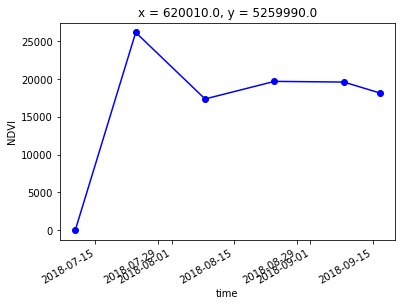

In [5]:
ds.isel(x=333, y=667).NDVI.plot.line('b-o')